#PyTorch で再帰的ニューラルネットワーク (Recurrent Neural Network, RNN) を使う．

Recurrent Neural Network (RNN) は系列データを扱う際によく用いられる NN モデル．  
入力が入力データと一つ前の出力 (最初はランダムやゼロベクトル) ，出力は 1 個．
現在の時刻を t とすると，次時刻 (t+1) の入力は入慮データ $x_{t+1}$ と一つ前の出力 $o_{t}$ となり，出力は $o_{t+1}$ となる．  
RNN のモデルは一つのネットワーク構造であり，そこに系列のすべてのデータが先頭から順番に入力されていく．時間軸方向に展開して図示されることも多い．  

RNN の問題の一つが勾配消失．学習が先頭方向に伝播していくうちに勾配が消失していき，情報が過去になると参照できなくなってしまう．  
それを防ぐために Long Short-term Memory (LSTM) が提案された．  
LSTM は勾配消失を防ぐために勾配逆伝播時に学習率をかけずそのまま伝える．そのままでは学習できないので，ゲートと呼ばれる機構を追加することで情報を伝えるかどうかや入出力をどう扱うかなどを学習させる．  
これにより勾配消失を気にせず系列データを扱えるようになった．  
ゲート機構などの追加によりパラメータ数が大きく増えることになったため，その問題を改良するための機構がいろいろと提案された．その中の一つが Gated Recurrent Unit (GRU)．問題によっては LSTM と同等の性能を示す．しかし言語系だと必ずしも良い性能を示さない場合もある．

LSTM は系列データ一般で扱える構造であり，言語系に限って用いられるものではない．  
最近の研究ではよくつかわれる構造なので，一通り扱えるようにしよう．

## ただの系列データ

## 言語データ

# LSTM を扱う（普通の系列データ）

系列データの再現をして，LSTM の扱い方に慣れる．
$\sin$ 波を再現してみる．


## 最初のいろいろ

In [1]:
# 最初のいろいろ
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

## データセットを作る．

pytorch の LSTM では入力テンソルは 3 次元．  

具体的なサイズは Sequence_Length x Batch_Size x Vector_Size．

今回の例では

- Sequnece_size（入力時系列長）= 50, 
- Vector_Size（入力ベクトルサイズ）= 1 

のテンソルを入力する（Batch_Sizeは後述）．

In [2]:
# 通常の sin 波

import math

def mkDataSet(data_size, data_length=50, freq=60.):
    """
    params
      data_size : データセットのサイズ
      data_length : 各データの時系列長
      freq : 周波数
    returns
      train_x : トレーニングデータ（t=1,2,...,size-1の値)
      train_t : トレーニングデータのラベル（t=sizeの値）
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq)] 
                        for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t

In [3]:
# 通常の sin 波にノイズを正規分布に従って乗せる．

import math
import numpy as np

def mkDataSet(data_size, data_length=50, freq=60., noise=0.02):
    """
    params
      data_size : データセットサイズ
      data_length : 各データの時系列長
      freq : 周波数
      noise : ノイズの振幅
    returns
      train_x : トレーニングデータ（t=1,2,...,size-1の値)
      train_t : トレーニングデータのラベル（t=sizeの値）
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) 
        + np.random.normal(loc=0.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t

[[[-0.017394270723622908], [0.1350553363536139], [0.2061483571050334], [0.29822275925955], [0.4283789631051123], [0.5060422301774505], [0.5868990842824324], [0.6678091574588204], [0.7449354146921152], [0.8206759064357051], [0.873164812340815], [0.9294881031574744], [0.948161468276896], [0.9660320999233478], [1.0006172577958394], [1.013063249174554], [0.9961536486601139], [1.0001467234703645], [0.9494444901297271], [0.8916184023047086], [0.8636245399023437], [0.8198153958856887], [0.7353333392476931], [0.6573224670449814], [0.5885102576061467], [0.47611983388781876], [0.3932068502593654], [0.2979386720527161], [0.23073270599052564], [0.1045530664847543], [-0.041541073076721995], [-0.08849295502385425], [-0.20405177995549667], [-0.30506732125493213], [-0.3988959426099437], [-0.4904526651169874], [-0.5899616908939056], [-0.6557051566655909], [-0.7415759334346035], [-0.8211686028162409], [-0.8303606490740866], [-0.892040887664247], [-0.9791091475067486], [-0.9871085049957806], [-0.99531607

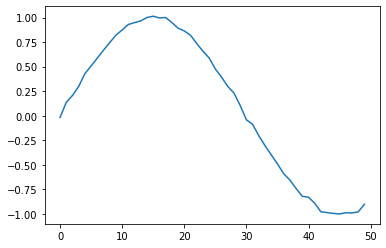

In [4]:
import matplotlib.pyplot as plt

train_x, train_t = mkDataSet(data_size=1)


print(train_x, train_t)
plt.plot(train_x[0])
plt.show()



In [5]:
# モデル
import torch
import torch.nn as nn

class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output

In [6]:
from torch.optim import SGD

def main():
    training_size = 100 #traning dataのデータ数
    epochs_num = 1000 #traningのepoch回数
    hidden_size = 5 #LSTMの隠れ層の次元数

    train_x, train_t = mkDataSet(training_size) #Datasetの作成

    model = Predictor(1, hidden_size, 1) #modelの宣言

    criterion = nn.MSELoss() #評価関数の宣言
    optimizer = SGD(model.parameters(), lr=0.01) #最適化関数の宣言

    for epoch in range(epochs_num):
      # training
      running_loss = 0.0
      training_accuracy = 0.0
      for i in range(training_size):
          optimizer.zero_grad()
          data = torch.tensor([train_x[i]])
          label = torch.tensor([train_t[i]])

          output = model(data)

          loss = criterion(output, label)
          loss.backward()
          optimizer.step()

          #print(loss.item())
          running_loss += loss.item()
          #print(np.sum(np.abs(output.item()-label.item()) < 0.1))
          training_accuracy += np.sum(np.abs(output.item()-label.item()) < 0.1) #outputとlabelの誤差が0.1以内なら正しいとみなす。
      training_accuracy /= training_size
      print('%d loss: %.3f, training_accuracy: %.5f' % (epoch + 1, running_loss, training_accuracy))

if __name__ == '__main__':
    main()

1 loss: 42.381, training_accuracy: 0.09000
2 loss: 30.478, training_accuracy: 0.09000
3 loss: 18.701, training_accuracy: 0.12000
4 loss: 10.388, training_accuracy: 0.12000
5 loss: 6.435, training_accuracy: 0.15000
6 loss: 4.852, training_accuracy: 0.16000
7 loss: 4.137, training_accuracy: 0.17000
8 loss: 3.728, training_accuracy: 0.19000
9 loss: 3.443, training_accuracy: 0.22000
10 loss: 3.221, training_accuracy: 0.23000
11 loss: 3.036, training_accuracy: 0.25000
12 loss: 2.876, training_accuracy: 0.25000
13 loss: 2.734, training_accuracy: 0.27000
14 loss: 2.608, training_accuracy: 0.28000
15 loss: 2.493, training_accuracy: 0.28000
16 loss: 2.389, training_accuracy: 0.28000
17 loss: 2.293, training_accuracy: 0.28000
18 loss: 2.205, training_accuracy: 0.28000
19 loss: 2.124, training_accuracy: 0.29000
20 loss: 2.048, training_accuracy: 0.31000
21 loss: 1.977, training_accuracy: 0.32000
22 loss: 1.911, training_accuracy: 0.33000
23 loss: 1.850, training_accuracy: 0.33000
24 loss: 1.791, 

batch 用に batch size を設定して，それに合わせてデータを作る．

Torch.Tensor で Sequence_Length x Batch_Size x Vector_Size の形式に
合うように作る

In [7]:
# Batch 処理用関数を作る．
def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)

In [8]:
from torch.optim import SGD

def main():
    training_size = 100 #traning dataのデータ数
    epochs_num = 1000 #traningのepoch回数
    hidden_size = 5 #LSTMの隠れ層の次元数

    train_x, train_t = mkDataSet(training_size) #Datasetの作成

    model = Predictor(1, hidden_size, 1) #modelの宣言

    criterion = nn.MSELoss() #評価関数の宣言
    optimizer = SGD(model.parameters(), lr=0.01) #最適化関数の宣言

    batch_size = 10

    for epoch in range(epochs_num):
      # training
      running_loss = 0.0
      training_accuracy = 0.0

      for i in range(int(training_size / batch_size)):
        optimizer.zero_grad()

        data, label = mkRandomBatch(train_x, train_t, batch_size)

        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        training_accuracy += np.sum(np.abs(output.detach().numpy()-label.detach().numpy()) < 0.1) #outputとlabelの誤差が0.1以内なら正しいとみなす。
      training_accuracy /= training_size
      print('%d loss: %.3f, training_accuracy: %.5f' % (epoch + 1, running_loss, training_accuracy))

if __name__ == '__main__':
    main()

1 loss: 3.590, training_accuracy: 0.13000
2 loss: 3.434, training_accuracy: 0.07000
3 loss: 3.298, training_accuracy: 0.08000
4 loss: 2.938, training_accuracy: 0.09000
5 loss: 3.124, training_accuracy: 0.13000
6 loss: 2.981, training_accuracy: 0.07000
7 loss: 2.889, training_accuracy: 0.09000
8 loss: 2.808, training_accuracy: 0.17000
9 loss: 2.291, training_accuracy: 0.14000
10 loss: 2.457, training_accuracy: 0.12000
11 loss: 2.232, training_accuracy: 0.15000
12 loss: 2.020, training_accuracy: 0.10000
13 loss: 1.993, training_accuracy: 0.14000
14 loss: 1.772, training_accuracy: 0.20000
15 loss: 1.786, training_accuracy: 0.12000
16 loss: 1.452, training_accuracy: 0.16000
17 loss: 1.510, training_accuracy: 0.12000
18 loss: 1.344, training_accuracy: 0.09000
19 loss: 1.056, training_accuracy: 0.13000
20 loss: 0.992, training_accuracy: 0.18000
21 loss: 1.230, training_accuracy: 0.19000
22 loss: 0.998, training_accuracy: 0.13000
23 loss: 0.768, training_accuracy: 0.12000
24 loss: 0.836, trai

In [9]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0)
        output = self.output_layer(output[:, -1, :])

        return output

def mkDataSet(data_size, data_length=50, freq=60., noise=0.00):
    """
    params\n
    data_size : データセットサイズ\n
    data_length : 各データの時系列長\n
    freq : 周波数\n
    noise : ノイズの振幅\n
    returns\n
    train_x : トレーニングデータ（t=1,2,...,size-1の値)\n
    train_t : トレーニングデータのラベル（t=sizeの値）\n
    """
    train_x = []
    train_t = []

    for offset in range(data_size):
        train_x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=0.0, scale=noise)] for i in range(data_length)])
        train_t.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return train_x, train_t

def mkRandomBatch(train_x, train_t, batch_size=10):
    """
    train_x, train_tを受け取ってbatch_x, batch_tを返す。
    """
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x), torch.tensor(batch_t)

def main():
    training_size = 10000
    test_size = 1000
    epochs_num = 1000
    hidden_size = 5
    batch_size = 100

    train_x, train_t = mkDataSet(training_size)
    test_x, test_t = mkDataSet(test_size)

    model = Predictor(1, hidden_size, 1)
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01)

    for epoch in range(epochs_num):
        # training
        running_loss = 0.0
        training_accuracy = 0.0
        for i in range(int(training_size / batch_size)):
            optimizer.zero_grad()

            data, label = mkRandomBatch(train_x, train_t, batch_size)

            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            training_accuracy += np.sum(np.abs(output.detach().numpy()-label.detach().numpy()) < 0.1) #outputとlabelの誤差が0.1以内なら正しいとみなす。

        #test
        test_accuracy = 0.0
        for i in range(int(test_size / batch_size)):
            offset = i * batch_size
            data, label = torch.tensor(test_x[offset:offset+batch_size]), torch.tensor(test_t[offset:offset+batch_size])
            output = model(data, None)

            test_accuracy += np.sum(np.abs(output.detach().numpy() - label.detach().numpy()) < 0.1)
        
        training_accuracy /= training_size
        test_accuracy /= test_size

        print('%d loss: %.3f, training_accuracy: %.5f, test_accuracy: %.5f' % (
            epoch + 1, running_loss, training_accuracy, test_accuracy))


if __name__ == '__main__':
    main()


1 loss: 43.310, training_accuracy: 0.07100, test_accuracy: 0.08400
2 loss: 30.328, training_accuracy: 0.08130, test_accuracy: 0.08400
3 loss: 15.354, training_accuracy: 0.11470, test_accuracy: 0.11900
4 loss: 6.927, training_accuracy: 0.13470, test_accuracy: 0.15300
5 loss: 4.808, training_accuracy: 0.15050, test_accuracy: 0.15300
6 loss: 4.137, training_accuracy: 0.17660, test_accuracy: 0.18600
7 loss: 3.782, training_accuracy: 0.17560, test_accuracy: 0.18600
8 loss: 3.504, training_accuracy: 0.18090, test_accuracy: 0.20200
9 loss: 3.308, training_accuracy: 0.19570, test_accuracy: 0.20200
10 loss: 3.094, training_accuracy: 0.19650, test_accuracy: 0.20200
11 loss: 2.893, training_accuracy: 0.20460, test_accuracy: 0.20200
12 loss: 2.781, training_accuracy: 0.20580, test_accuracy: 0.23500
13 loss: 2.607, training_accuracy: 0.23160, test_accuracy: 0.23500
14 loss: 2.498, training_accuracy: 0.22770, test_accuracy: 0.23500
15 loss: 2.415, training_accuracy: 0.22820, test_accuracy: 0.23500
1

## 言語でも LSTM

こちらを参考にやってみよう．
https://qiita.com/m__k/items/841950a57a0d7ff05506



## データのダウンロードと自分の Google Drive への展開
上の URL の内容を参考に，自分の Google Drive にデータをダウンロードして展開する．

まず左側一番下「フォルダ」アイコンをクリックして，次に上の方のアイコン群の一番右のドライブのマウントのアイコンをクリックする．そして自分のドライブをマウントしてから下のセルを実行してください．

In [10]:
%cd "/content/drive/MyDrive/Colab Notebooks"
%ls

!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar xvf "ldcc-20140209.tar.gz"

ストリーミング出力は最後の 5000 行に切り捨てられました。
text/smax/smax-6833065.txt
text/smax/smax-6833494.txt
text/smax/smax-6833579.txt
text/smax/smax-6834422.txt
text/smax/smax-6834562.txt
text/smax/smax-6834765.txt
text/smax/smax-6834990.txt
text/smax/smax-6835318.txt
text/smax/smax-6838218.txt
text/smax/smax-6838260.txt
text/smax/smax-6838332.txt
text/smax/smax-6838453.txt
text/smax/smax-6838514.txt
text/smax/smax-6838627.txt
text/smax/smax-6838702.txt
text/smax/smax-6842164.txt
text/smax/smax-6842219.txt
text/smax/smax-6842269.txt
text/smax/smax-6842402.txt
text/smax/smax-6842629.txt
text/smax/smax-6842882.txt
text/smax/smax-6843206.txt
text/smax/smax-6845003.txt
text/smax/smax-6847081.txt
text/smax/smax-6849018.txt
text/smax/smax-6850114.txt
text/smax/smax-6850391.txt
text/smax/smax-6850789.txt
text/smax/smax-6851590.txt
text/smax/smax-6851919.txt
text/smax/smax-6853063.txt
text/smax/smax-6853346.txt
text/smax/smax-6853751.txt
text/smax/smax-6854198.txt
text/smax/smax-6855347.txt
text/smax/smax-6855946.

## データセットの作成

In [11]:
import os
from glob import glob
import pandas as pd
import linecache

# カテゴリを配列で取得
categories = [name for name in os.listdir("text") if os.path.isdir("text/" + name)]
print(categories)

datasets = pd.DataFrame(columns=["title", "category"])
for cat in categories:
    path = "text/" + cat + "/*.txt"
    files = glob(path)
    for text_name in files:
        title = linecache.getline(text_name, 3)
        s = pd.Series([title, cat], index=datasets.columns)
        datasets = datasets.append(s, ignore_index=True)

# データフレームシャッフル
datasets = datasets.sample(frac=1).reset_index(drop=True)
datasets.head()

['smax', 'topic-news', 'dokujo-tsushin', 'livedoor-homme', 'peachy', 'kaden-channel', 'it-life-hack', 'movie-enter', 'sports-watch']


,title,category
0,HKT48、メンバー5人の脱退を発表\n,topic-news
1,リュ・シウォンがソウルをPR！ YouTubeで限定配信\n,peachy
2,ダルビッシュが2失点、みのもんたは「メジャーじゃ通用しない」\n,sports-watch
3,【韓国ニュース】月一で来日し、日本全国でデモする韓国の農民とは\n,topic-news
4,おもしろ回答が続々登場！ 期待大の日本語版「Siri」の実力は？【話題】\n,kaden-channel


## embedding 層について

In [12]:
import torch
import torch.nn as nn

# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
embeds = nn.Embedding(10, 6) # (Embedding(単語の合計数, ベクトル次元数))

# ３行目の要素を取り出したいならば
w1 = torch.tensor([2])
print(embeds(w1))

# 3行目、5行目、１０行目の要素を取り出したいならば、
w2 = torch.tensor([2,4,9])
print(embeds(w2))


tensor([[-0.2628,  0.2218, -0.8308,  0.0407, -0.0356, -1.1262]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.2628,  0.2218, -0.8308,  0.0407, -0.0356, -1.1262],
        [ 0.0650, -1.4521, -1.4932, -2.3037,  0.4923, -3.0139],
        [-0.3156,  0.5176,  0.3120,  0.5215, -0.7947, -1.4132]],
       grad_fn=<EmbeddingBackward0>)


## MeCab を Google Colab にインストール

In [13]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [14]:
import MeCab
import re
import torch

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

# テスト
test = "【人工知能】は「人間」の仕事を奪った"
print(make_wakati(test))
# ['人工', '知能', 'は', '人間', 'の', '仕事', 'を', '奪っ', 'た']

# 単語ID辞書を作成する
word2index = {}
for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))
# vocab size :  13229

# 文章を単語IDの系列データに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return torch.tensor([word2index[w] for w in wakati], dtype=torch.long)

# テスト
test = "例のあのメニューも！ニコニコ超会議のフードコートメニュー14種類紹介（前半）"
print(sentence2index(test))
# tensor([11320,     3,   449,  5483,    26,  3096,  1493,  1368,     3, 11371, 7835,   174,  8280])

['人工', '知能', 'は', '人間', 'の', '仕事', 'を', '奪っ', 'た']
vocab size :  13229
tensor([ 9363,     2,   628,  6242,    52,  4122,    68,  3732,     2, 11955,
         2375,   288, 10555])


## 文章のマトリクス化

In [15]:
# 全単語数を取得
VOCAB_SIZE = len(word2index)
# 単語のベクトル数
EMBEDDING_DIM = 10
test = "ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」"
# 単語IDの系列データに変換
inputs = sentence2index(test)
# 各単語のベクトルをまとめて取得
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
sentence_matrix = embeds(inputs)
print(sentence_matrix.size())
print(sentence_matrix)


torch.Size([13, 10])
tensor([[-0.4102, -1.1206,  0.0304, -0.2769, -0.3550,  0.5133,  0.0040,  0.5707,
         -1.0205,  0.4417],
        [-0.8073,  0.4094, -0.8007, -0.4897, -0.8047, -0.7024, -0.1898,  0.1867,
          0.3723,  1.1791],
        [ 1.9563,  1.4042,  0.9385,  0.1959, -0.3115,  1.4337, -0.7955, -1.9573,
         -0.8975,  1.0817],
        [ 0.0225,  0.3157, -0.3488, -0.9969,  0.0834, -0.7941, -0.9717,  0.5789,
         -0.5325,  0.6683],
        [-0.1959, -1.1010, -1.2493,  1.0232,  1.6102,  0.9946,  0.5091,  0.6281,
         -0.4470, -0.0510],
        [ 1.7560,  0.3625,  0.1709, -1.2330, -1.3216, -0.5097,  0.3762, -0.6282,
          0.5797, -0.6570],
        [ 0.7871, -0.1499,  0.1082, -0.1816, -0.8689,  0.4437,  0.9862, -2.4132,
          0.5329,  1.0795],
        [ 0.2665,  0.6298,  0.2484,  0.1738, -0.1256,  0.3212,  0.5380, -0.9090,
         -0.5874, -0.7512],
        [-0.8073,  0.4094, -0.8007, -0.4897, -0.8047, -0.7024, -0.1898,  0.1867,
          0.3723,  1.1791]

LSTM に入力するために torch.tensor() で，形を合わせる．

先の例と一緒．Sequence_Length x Batch_Size x Vector_Size．

簡単のために Batch_Size == 1 になっている．

1 データずつ入力していく形．

In [16]:
sentence_matrix.view(len(sentence_matrix), 1, -1).size()

torch.Size([13, 1, 10])

## モデルの定義

In [17]:
# 工夫せず入れてみて様子を見る．

VOCAB_SIZE = len(word2index)
EMBEDDING_DIM = 10
HIDDEN_DIM = 128
embeds = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)
s1 = "震災をうけて感じた、大切だと思ったこと"
print(make_wakati(s1))
#['震災', 'を', 'うけ', 'て', '感じ', 'た', '大切', 'だ', 'と', '思っ', 'た', 'こと']

inputs1 = sentence2index(s1)
emb1 = embeds(inputs1)
lstm_inputs1 = emb1.view(len(inputs1), 1, -1)
out1, out2 = lstm(lstm_inputs1)
print(out1)
print(out2)

['震災', 'を', 'うけ', 'て', '感じ', 'た', '大切', 'だ', 'と', '思っ', 'た', 'こと']
tensor([[[-0.0237, -0.0181, -0.0576,  ..., -0.0159, -0.0524,  0.0554]],

        [[-0.0517,  0.0071,  0.0299,  ...,  0.0055, -0.0939,  0.0840]],

        [[-0.0742,  0.0275,  0.0295,  ..., -0.0036, -0.0700,  0.0524]],

        ...,

        [[-0.0457, -0.0827,  0.0677,  ..., -0.1240,  0.1364,  0.0896]],

        [[-0.0685, -0.0680,  0.0880,  ..., -0.0480,  0.1675, -0.0247]],

        [[-0.0550, -0.0074,  0.0701,  ...,  0.0056,  0.1001, -0.0548]]],
       grad_fn=<StackBackward0>)
(tensor([[[-5.5006e-02, -7.3703e-03,  7.0077e-02, -2.4036e-02,  8.2672e-02,
           7.9190e-02,  7.3792e-02,  2.7163e-02, -5.9204e-03, -1.7003e-02,
          -7.0312e-02,  8.5679e-02,  1.5249e-02, -4.9945e-03,  5.0656e-02,
          -1.1560e-01, -2.3506e-02, -6.2087e-02, -1.6791e-02, -1.3384e-02,
           6.0142e-02, -4.6701e-02,  3.1265e-02, -3.1939e-02,  1.0832e-01,
           1.4172e-01, -4.1730e-02,  3.8400e-03, -1.4461e-02,  1.9452e-0

## モデル

In [18]:
# 実際のモデル．LSTM から MLP につなげて記事を分類する．

# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        embeds = self.word_embeddings(sentence)
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

In [19]:
# 記事のカテゴリとインデックスの対応を取る．
# それ用に関数も作る．
category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

print(category2tensor("it-life-hack"))


{'smax': 0, 'topic-news': 1, 'dokujo-tsushin': 2, 'livedoor-homme': 3, 'peachy': 4, 'kaden-channel': 5, 'it-life-hack': 6, 'movie-enter': 7, 'sports-watch': 8}
tensor([6])


## 学習

In [20]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
# 元データを7:3に分ける（7->学習、3->テスト）
traindata, testdata = train_test_split(datasets, train_size=0.7)

# 単語のベクトル次元数
EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 各エポックの合計loss値を格納する
losses = []
# 100ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for epoch in range(100):
    all_loss = 0
    for title, cat in zip(traindata["title"], traindata["category"]):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = sentence2index(title)
        # 順伝播の結果を受け取る
        out = model(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss)
print("done.")

epoch 0 	 loss 11005.221505343914
epoch 1 	 loss 10093.491494089365
epoch 2 	 loss 9429.258344840258
epoch 3 	 loss 8962.14132435061
epoch 4 	 loss 8540.927570622414
epoch 5 	 loss 8084.78439811198
epoch 6 	 loss 7562.8278852126095
epoch 7 	 loss 7044.88155511138
epoch 8 	 loss 6580.574593593483
epoch 9 	 loss 6155.249505487183
epoch 10 	 loss 5811.846247675145
epoch 11 	 loss 5458.899965668483
epoch 12 	 loss 5115.740203244852
epoch 13 	 loss 4761.572188150843
epoch 14 	 loss 4393.626723060082
epoch 15 	 loss 4004.2638880735904
epoch 16 	 loss 3587.605616714083
epoch 17 	 loss 3152.3647837640615
epoch 18 	 loss 2693.971816260557
epoch 19 	 loss 2296.39353814852
epoch 20 	 loss 1836.6059075770845
epoch 21 	 loss 1418.9955111632762
epoch 22 	 loss 1044.7177010698992
epoch 23 	 loss 869.1424734685451
epoch 24 	 loss 863.8070940987204
epoch 25 	 loss 456.4821255442978
epoch 26 	 loss 299.2187498716164
epoch 27 	 loss 205.81205800765684
epoch 28 	 loss 150.3387471119281
epoch 29 	 loss 117

バッチ処理してないので遅い．

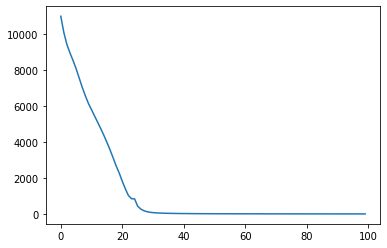

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

## 予測精度の確認

In [22]:
# テストデータの母数計算
test_num = len(testdata)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for title, category in zip(testdata["title"], testdata["category"]):
        # テストデータの予測
        inputs = sentence2index(title)
        out = model(inputs)

        # outの一番大きい要素を予測結果をする
        _, predict = torch.max(out, 1)

        answer = category2tensor(category)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)
# predict :  0.6118391323994578

predict :  0.5901491188431993


## バッチ処理をしてみる．

こちらを参照．

https://qiita.com/m__k/items/db1a81bb06607d5b0ec5

## 辞書再設定（バッチ処理対応用）

In [23]:
word2index = {}
# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("vocab size : ", len(word2index))

vocab size :  13230


## データセット再構築

バッチ処理用にパディング（詰め物）をする．

In [24]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

cat2index = {}
for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)

def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati]

def category2index(cat):
    return [cat2index[cat]]

index_datasets_title_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  index_title = sentence2index(title)
  index_category = category2index(category)
  index_datasets_title_tmp.append(index_title)
  index_datasets_category.append(index_category)
  if max_len < len(index_title):
    max_len = len(index_title)

# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
index_datasets_title = []
for title in index_datasets_title_tmp:
  for i in range(max_len - len(title)):
    title.insert(0, 0) # 前パディング
#     title.append(0)　# 後ろパディング
  index_datasets_title.append(title)

train_x, test_x, train_y, test_y = train_test_split(index_datasets_title, index_datasets_category, train_size=0.7)

# データをバッチでまとめるための関数
def train2batch(title, category, batch_size=100):
  title_batch = []
  category_batch = []
  title_shuffle, category_shuffle = shuffle(title, category)
  for i in range(0, len(title), batch_size):
    title_batch.append(title_shuffle[i:i+batch_size])
    category_batch.append(category_shuffle[i:i+batch_size])
  return title_batch, category_batch

## モデル再設定

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# GPUを使うために必要
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        # <pad>の単語IDが0なので、padding_idx=0としている
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # batch_first=Trueが大事！
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        _, lstm_out = self.lstm(embeds)
        # lstm_out[0].size() = (1 × batch_size × hidden_dim)
        tag_space = self.hidden2tag(lstm_out[0])
        # tag_space.size() = (1 × batch_size × tagset_size)

        # (batch_size × tagset_size)にするためにsqueeze()する
        tag_scores = self.softmax(tag_space.squeeze())
        # tag_scores.size() = (batch_size × tagset_size)

        return tag_scores

# 単語の埋め込み次元数上げた。精度がそこそこアップ！ハイパーパラメータのチューニング大事。
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
VOCAB_SIZE = len(word2index)
TAG_SIZE = len(categories)
# to(device)でモデルがGPU対応する
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
loss_function = nn.NLLLoss()
# SGDからAdamに変更。特に意味はなし
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 学習（バッチ処理版）

In [26]:
losses = []
for epoch in range(100):
    all_loss = 0
    title_batch, category_batch = train2batch(train_x, train_y)
    for i in range(len(title_batch)):
        batch_loss = 0

        model.zero_grad()

        # 順伝搬させるtensorはGPUで処理させるためdevice=にGPUをセット
        title_tensor = torch.tensor(title_batch[i], device=device)
        # category_tensor.size() = (batch_size × 1)なので、squeeze()
        category_tensor = torch.tensor(category_batch[i], device=device).squeeze()

        out = model(title_tensor)

        batch_loss = loss_function(out, category_tensor)
        batch_loss.backward()
        optimizer.step()

        all_loss += batch_loss.item()
    print("epoch", epoch, "\t" , "loss", all_loss)
    if all_loss < 0.1: break
print("done.")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 94.96916472911835
epoch 1 	 loss 64.53739416599274
epoch 2 	 loss 45.11484485864639
epoch 3 	 loss 30.017165809869766
epoch 4 	 loss 18.693860977888107
epoch 5 	 loss 10.753214076161385
epoch 6 	 loss 5.583321340382099
epoch 7 	 loss 2.7774950321763754
epoch 8 	 loss 1.586432309821248
epoch 9 	 loss 1.0206130985170603
epoch 10 	 loss 0.7019515004940331
epoch 11 	 loss 0.558217232581228
epoch 12 	 loss 0.5069282012991607
epoch 13 	 loss 0.4455959440674633
epoch 14 	 loss 0.35909657925367355
epoch 15 	 loss 0.3205331629142165
epoch 16 	 loss 0.28381205908954144
epoch 17 	 loss 0.24744730663951486
epoch 18 	 loss 0.2309718676842749
epoch 19 	 loss 0.21175059978850186
epoch 20 	 loss 0.2047311856294982
epoch 21 	 loss 0.19262859469745308
epoch 22 	 loss 0.18362156761577353
epoch 23 	 loss 0.17892777174711227
epoch 24 	 loss 0.1711889004218392
epoch 25 	 loss 0.16884984681382775
epoch 26 	 loss 0.15990477218292654
epoch 27 	 loss 0.16012168035376817
epoch 28 	 loss 0.16882503

## チェック（バッチ処理版）

In [27]:
test_num = len(test_x)
a = 0
with torch.no_grad():
    title_batch, category_batch = train2batch(test_x, test_y)

    for i in range(len(title_batch)):
        title_tensor = torch.tensor(title_batch[i], device=device)
        category_tensor = torch.tensor(category_batch[i], device=device)

        out = model(title_tensor)
        _, predicts = torch.max(out, 1)
        for j, ans in enumerate(category_tensor):
            if predicts[j].item() == ans.item():
                a += 1
print("predict : ", a / test_num)
# predict :  0.6967916854948034

predict :  0.6642566651604157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
